Resources:

http://forums.fast.ai/t/fastai-for-image-captioning/17003/8

https://github.com/githubharald/SimpleHTR/blob/master/src/DataLoader.py

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.fastai.conv_learner import *
from fastai.fastai.text import *

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
!ls {PATH}

line_labels.csv  lines	lines.tgz  models  tmp	words  words.csv  words.tgz


In [5]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

device = torch.cuda.current_device()
device

0

In [6]:
from PIL import Image

def open_image(fname):
    f = fname if fname.endswith('.png') else fname+'.png'
    return Image.open(f'{PATH}/lines/{f}')

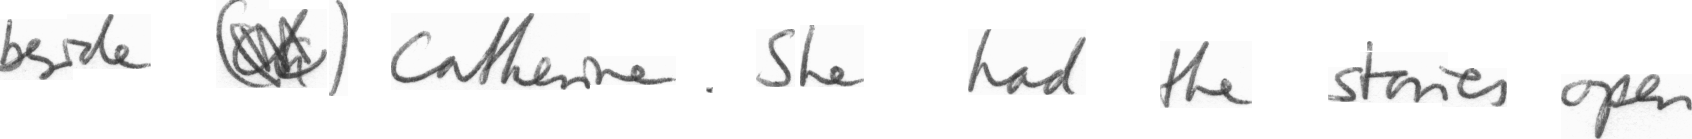

In [7]:
open_image('r06-143-01')

# Lines

### Explore Data

In [ ]:
line_labels = pd.read_csv(f'{PATH}/ascii/lines.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])

In [ ]:
line_labels.tail()

In [ ]:
line_labels['text'] = line_labels.apply(lambda row: row.value.replace('|', ' '), axis=1)
line_labels.tail()

### Tokenize Labels

In [ ]:
tokens = Tokenizer().proc_all_mp(partition_by_cores(line_labels.text))

In [ ]:
np.argmax([len(o) for o in tokens])

In [ ]:
tokens[4964], len(tokens[4964])

In [ ]:
np.percentile([len(o) for o in tokens], 99)

### Numericalize Labels

In [ ]:
freq = Counter(word for line in tokens for word in line)
freq.most_common(25)

In [ ]:
max_vocab=40000
min_freq=2

In [ ]:
itos = [word for word,count in freq.most_common(max_vocab) if count>min_freq]
itos.insert(0, '_unk_')
itos.insert(1, '_pad_')

stoi = collections.defaultdict(lambda: 0, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[word] for word in line]) for line in tokens])

In [ ]:
len(ids), len(itos)#, len(stoi)

In [ ]:
def idstoline(ids):
    return ' '.join(itos[i] for i in ids)

In [ ]:
idstoline(ids[0])

In [ ]:
np.save(TMP_PATH/'ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'itos.pkl', 'wb'))

In [ ]:
# add ids to df
line_labels['ids'] = [' '.join(str(p) for p in o) for o in ids]
line_labels.tail()

### load Wikitext103 pretrained model

In [ ]:
pre_path = Path('data/aclImdb/models/wt103')
pre_lm_path = pre_path/'fwd_wt103.h5'

In [ ]:
wgts = torch.load(pre_lm_path, map_location=lambda storage, loc: storage )

In [ ]:
dec_wgts = to_np(wgts['1.decoder.weight'])
row_mean = dec_wgts.mean(0)
dec_wgts.shape

In [ ]:
wiki_itos = pickle.load((pre_path/'itos_wt103.pkl').open('rb'))
wiki_stoi = collections.defaultdict(lambda: -1, {v:k for k,v in enumerate(wiki_itos)})

In [ ]:
def create_emb(dec_wgts, itos, em_sz):
    row_mean = torch.from_numpy(dec_wgts.mean(0))
    # embedding: simple lookup table - input=index; output=word vector
    # embeddings: rows = vocab size (4085), columns = determined by wiki pre-trained weights (400)
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    # learnable pytorch module has a 'weight' attribute => Variable
    # 'weight' attribute has a 'data' attribute => Tensor
    wgts = emb.weight.data
    # iterate through vocabulary and replace found words w/ pretrained vector weights if available
    for idx,word in enumerate(itos):
        wiki_int = wiki_stoi[word]
        wgts[idx] = torch.from_numpy(dec_wgts[wiki_int]) if wiki_int >= 0 else row_mean
    
    return emb

In [ ]:
emb_dec = create_emb(dec_wgts, itos, em_sz)

In [ ]:
torch.save(emb_dec, TMP_PATH/'embedding_decoder.h5')

In [ ]:
wgts['0.encoder.weight'] = T(new_w)
# weight tying
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [ ]:
torch.save(wgts, TMP_PATH/'pretrained.h5')

In [ ]:
wgts = torch.load(TMP_PATH/'pretrained.h5')
dec_wgts = to_np(wgts['1.decoder.weight'])

### Save DF as CSV

In [7]:
emb_dec = torch.load(TMP_PATH/'embedding_decoder.h5')

In [8]:
ids = np.load(TMP_PATH/'ids.npy')
itos = pickle.load(open(TMP_PATH/'itos.pkl', 'rb'))

In [9]:
CSV = PATH/'line_labels.csv'

In [10]:
# line_labels.to_csv(CSV, columns=['filename', 'ids'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,ids
0,a01-000u-00,1 9 32 1311 7 500 41 4 949 39
1,a01-000u-01,1 2 111 65 162 121 1312
2,a01-000u-02,1 16 7 25 104 28 9 387 6 162
3,a01-000u-03,1 894 501 4 41 4 1623 834 46
4,a01-000u-04,1 205 136 9 2148 26 3 708


In [11]:
len(csv)

13351

In [ ]:
# CSV.open().readlines()[:5]

### Get val_idxs

In [12]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

2003

### Model Data (rotate, normalize)

In [13]:
sz = 300
bs = 50

In [14]:
# use this md object to load image data w/ transforms

# These values were generated initially with tfms_from_model(resnet34)
stats = A([ 0.92025,  0.92025,  0.92025], [ 0.12774,  0.12774,  0.12774])

aug_tfms = [RandomRotate(1, mode=0), RandomLighting(0.05, 0.05)]

tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'lines', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, suffix='.png',
                                    continuous=True)

**Dataset**
- x: images (with aug_tfms)
- y: array of ints -> represent words in a line
    -- pre_pad=False, transpose_y=?????

In [15]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

In [16]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [17]:
def idstoline(ids):
    return ' '.join(itos[i] for i in ids)

In [18]:
ints = to_np(y[9]).astype(int)
idstoline(ints)

'_bos_ parties of northern rhodesia have agreed to _pad_ _pad_ _pad_'

In [ ]:
x[7].shape

### View image transforms

In [ ]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

In [ ]:
fig, axes = plt.subplots(4,1, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    ints = to_np(y[i]).astype(int)
    t = idstoline(ints)
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Determine size of dataset (2000 x 200)

In [ ]:
# create a dictionary comprehension of image sizes in the dataset
size_d = {k: PIL.Image.open(PATH/k).size for k in data.val_ds.fnames}

In [ ]:
row_sz,col_sz = list(zip(*size_d.values()))

In [ ]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [ ]:
plt.hist(row_sz)

In [ ]:
plt.hist(col_sz)

## Initial Seq2Seq

In [ ]:
# conv basis
# head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,em_sz))   # last layer has 7x7x512 in ResNet34
# learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)

In [19]:
vs = len(itos)

In [20]:
# f = vgg19
# conv_model = nn.Sequential(*children(f(True))[:-1])

f = resnet34
conv_model = nn.Sequential(*children(f(True))[:6])

In [23]:
to_gpu(conv_model)  # need to convert model weights to cuda
z = conv_model(T(x).permute(0,3,1,2))

In [24]:
z.size()

torch.Size([50, 128, 28, 28])

In [21]:
em_sz,sl = 400,20
# vocab_size = 4085
# batch_size = 50

In [75]:
class CNN_Encoder(nn.Module):
    def __init__(self, conv_model, em_sz, p_num):
        super().__init__()
        # self.c = conv_model[-2].num_features  #vgg
        self.c = conv_model[-1][-1].bn2.num_features  #resnet
        self.p_num = p_num
        
        self.pool = nn.AdaptiveMaxPool2d(self.p_num)      #(bs,128,7,7)
        self.fc1 = nn.Linear(self.c*self.p_num**2, 1000)
        self.fc2 = nn.Linear(1000, em_sz)

    def forward(self, inp):
        feats = conv_model(inp)                  #=> ([50, 128, ?, ?])  (bs,c,h,w)
        feats = self.pool(feats)                 #=> ([50, 128, 7, 7])
        feats = feats.view(-1, self.c*self.p_num**2)
#         feats = feats.permute(2,3,0,1).view(self.p_num**2,-1,self.c)  #(p_num**2,bs,c)
        feats = F.relu(self.fc1(feats))                   #(bs,1000)
        feats = self.fc2(feats)        
        return feats                 

In [80]:
# based on Show,Attend,Tell - https://github.com/parksunwoo/show_attend_and_tell_pytorch/blob/master/model.py

class Seq2SeqCNN_RNN(nn.Module):
    def __init__(self, conv_model, vs, em_sz, sl, nl=1, p_num=7):
        super().__init__()
        self.nl,self.em_sz,self.sl = nl,em_sz,sl   #=> 2, 20
        
        self.encoder = CNN_Encoder(conv_model, em_sz, p_num)

        self.emb = emb_dec #nn.Embedding.from_pretrained(emb_dec)  #(4085, 400)
        # self.emb = nn.Embedding(vs, em_sz) #=> Embedding(80, 400)
        self.gru = nn.GRU(em_sz, em_sz, num_layers=self.nl) #, dropout=0.1)
        self.drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz, vs) #=> ([256, 80])
        
    def forward(self, inp):
        ### Encoder (Conv Layer) ###
        bs = inp.shape[0]
        
        feats = self.encoder(inp)
        #_,bs,c = feats.size()   # need this because last batch isn't 50
        
        h = feats.unsqueeze(0)         #(1,bs,400)
    
        ### DECODER LOOP ###    loop through ~20 times -> for each word in output
        dec_inp = V(torch.ones(bs).long()) #=> ([bs])   # initialize first word (with _bos_) and then replace 
        res = []

        for i in range(self.sl):            
            emb = self.emb(dec_inp).unsqueeze(0)         # embedding => ([1, bs, 256])
            outp, h = self.gru(emb, h)                   # rnn => ([1, bs, 256]),  ([1, bs, 256])
            outp = self.out(self.drop(outp[0]))          # dropout, linear layer => ([256, 4085])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])   #=> ([64])
#             if (dec_inp==1).all(): break       # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)                  # stack up list of results into single tensor and return it

In [81]:
# categorical cross entropy loss
# list of probabilities for each character in vocab; target is correct character

def seq2seq_loss(input, target):    
    targ = target.transpose(0,1).contiguous()  # need to switch the axes to line up
    sl,bs = targ.size()   #=> ([13,50])
    sl_in,bs_in,nc = input.size()  #=> ([20, 50, 80])
        
    # tweak 1: align sequence lengths (input is always 20 but target often is less)
    if sl_in>sl: targ = F.pad(targ, (0,0,0,sl_in-sl)) # rank2 tensor requires 4 padding values
    # (padLeft, padRight, padTop, padBottom) => (before 1, after 1, before 0, after 0)
    # sequence length: add as much padding as necessary at the end
    
    # input = input[:sl]
    targ = targ[:sl_in,:].long()
    # cross_entropy expects rank2 tensor but we have sl * bs so we need to flatten out both
    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(input.view(-1,nc), targ.view(-1))  #=> ([1000, 80]), ([1000])

In [82]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqCNN_RNN(to_gpu(conv_model), vs, em_sz, sl)
# SingleModel => way to handle learning rate groups -> treats whole thing as single group
# easy way to turn pytorch module into fastai model
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

 70%|██████▉   | 158/227 [06:41<02:55,  2.54s/it, loss=17.7]

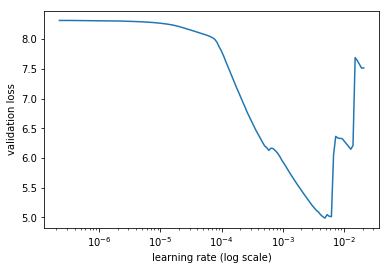

In [83]:
learn.lr_find(start_lr=1e-7)
learn.sched.plot()

In [84]:
lr = 2e-3

In [85]:
learn.fit(lr, 1, cycle_len=1)
#size:224,bs:50 -> 3.14
  # 2 fc layers -> 3.11
  # 3.10

epoch      trn_loss   val_loss                              
    0      2.965823   2.835906  


[2.835906493954542]

In [52]:
learn.fit(lr, 1, cycle_len=1)
#size:224,bs:50 -> 3.12
  # 2 fc layers -> 3.09

epoch      trn_loss   val_loss                              
    0      3.429499   3.964042  


[3.964042454231076]

In [92]:
learn.fit(lr, 1, cycle_len=5, wds=1e-7, use_clr=(20,5))
# sz:224,bs:50
# epoch      trn_loss   val_loss                              
#     0      3.105776   3.117618  
#     1      3.050825   3.117392                              
#     2      3.018535   3.07232                               
#     3      2.989161   3.079901                              
#     4      2.961748   3.067656 

# sz:128,bs:100

epoch      trn_loss   val_loss                              
    0      2.925323   2.899282  
    1      2.874386   2.842956                              
    2      2.83685    2.825052                              
    3      2.802042   2.833915                              
    4      2.759804   2.870392                              


[2.870391868963474]

In [39]:
learn.save('224-7iters')

### Test

In [86]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return idstoline(ints)
#     return ''.join([itos[i] for i in ints])

In [87]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

In [88]:
def decode(probs):
    # probs.shape = ([20, 50, 4085])
    probs = probs.permute(1, 0, 2).cpu().data.numpy()  #=> (50, 20, 4085)
    return np.argmax(probs, 2)                        #=> (50, 20)

In [89]:
x,y = next(iter(learn.data.val_dl))
probs = learn.model(V(x))                          
preds = decode(probs)

In [91]:
preds[1]

array([1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


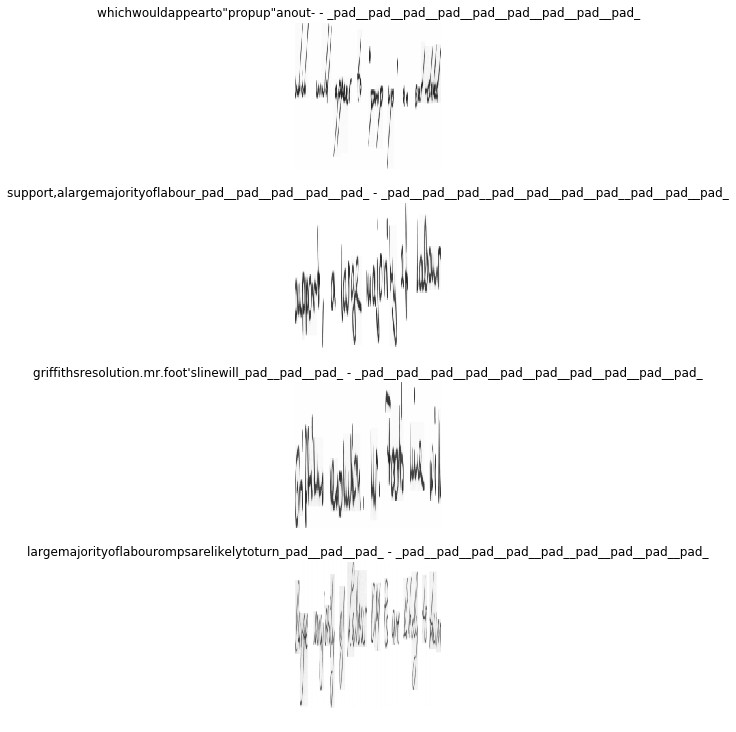

In [67]:
imgs = denorm(x)

fig, axes = plt.subplots(4,1, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i]) + ' - ' + label_text(preds[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

## Attention model

In [18]:
em_sz,sl = 400,20
# vocab_size = 4085
# batch_size = 50

In [34]:
class CNN_Encoder(nn.Module):
    def __init__(self, conv_model, em_sz, p_num):
        super().__init__()
        # self.c = conv_model[-2].num_features  #vgg
        self.c = conv_model[-1][-1].bn2.num_features  #resnet
        self.p_num = p_num
        
        self.pool = nn.AdaptiveMaxPool2d(self.p_num)      #(bs,128,7,7)
        self.fc = nn.Linear(self.c, em_sz)
    
    def forward(self, inp):
        feats = conv_model(inp)                  #=> ([50, 128, ?, ?])  (bs,c,h,w)
        feats = self.pool(feats)                 #=> ([50, 128, 7, 7])
        feats = feats.permute(2,3,0,1).view(self.p_num**2,-1,self.c)  #(p_num**2,bs,c)
        feats = self.fc(feats)                   #(49,bs,400)
     
        return feats                 

In [35]:
# based on Show,Attend,Tell - https://github.com/parksunwoo/show_attend_and_tell_pytorch/blob/master/model.py
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

#class ATTN_Decoder(nn.Module):


class Attn_RNN(nn.Module):
    def __init__(self, conv_model, vs, em_sz, sl=20, nl=1, p_num=7):
        super().__init__()
        self.encoder = CNN_Encoder(conv_model, em_sz, p_num)
        
        self.emb = emb_dec #nn.Embedding.from_pretrained(emb_dec)
        # self.emb = nn.Embedding(vs, em_sz) #=> Embedding(80, 256)
        self.gru = nn.GRU(em_sz, em_sz, num_layers=nl) #, dropout=0.1)
        self.drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz, vs) #=> ([256, 80])
        
        # setting up Attention Layers
        self.W1 = rand_p(em_sz, em_sz)
        self.l2 = nn.Linear(em_sz, em_sz) 
        self.l3 = nn.Linear(em_sz*2, em_sz) #=> ([768, 256])
        self.V = rand_p(em_sz)  #=> ([256])

        
    def forward(self, inp):
        ### Encoder (Conv Layer) ###
        feats = self.encoder(inp)
        mask_sz,bs,c = feats.size()             # need this because last batch isn't 50
        #h = feats.unsqueeze(0)             #(bs,256)
        
    
        ### DECODER LOOP ###    loop through ~20 times -> for each word in output
        dec_inp = V(torch.zeros(bs).long()) #=> ([bs])   # initialize first word (with _unk_??) and then replace 
        hidden = torch.zeros(1, 1, em_sz, device=device)
        res,attns = [],[]

        
        for i in range(sl):   
            # embedded input
            emb = self.emb(dec_inp) #=> ([50, 400])
            w1e = emb @ self.W1     #=> ([50, 400])     

            # hidden state
            #w2h = self.l2(h[-1])  #=> ([125, 300])
            w2h = self.l2(hidden)    #=> ([1, 1, 400])
            
            # non-linear activation
            u = F.tanh(w1e + w2h) #=> ([30, 125, 300])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = F.softmax(u @ self.V, 0)  #=> ([30, 125])
            attns.append(a)
            Xa = (a.unsqueeze(2) * feats).sum(0) #=> ([125, 256])
#             emb = self.emb(dec_inp) #=> ([125, 556])
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([125, 300])
            
            outp, hidden = self.gru(feats, wgt_enc.unsqueeze(0))

            outp = self.out(self.drop(outp[0]))          # dropout, linear layer => ([256, 4085])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])   #=> ([64])
#             if (dec_inp==1).all(): break       # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)                  # stack up list of results into single tensor and return it

In [36]:
# categorical cross entropy loss
# list of probabilities for each character in vocab; target is correct character

def seq2seq_loss(input, target):    
    targ = target.transpose(0,1).contiguous()  # need to switch the axes to line up
    sl,bs = targ.size()   #=> ([13,50])
    sl_in,bs_in,nc = input.size()  #=> ([20, 50, 80])
        
    # tweak 1: align sequence lengths (input is always 20 but target often is less)
    if sl_in>sl: targ = F.pad(targ, (0,0,0,sl_in-sl)) # rank2 tensor requires 4 padding values
    # (padLeft, padRight, padTop, padBottom) => (before 1, after 1, before 0, after 0)
    # sequence length: add as much padding as necessary at the end
    
    # input = input[:sl]
    targ = targ[:20,:].long()
    # cross_entropy expects rank2 tensor but we have sl * bs so we need to flatten out both
    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(input.view(-1,nc), targ.view(-1))  #=> ([1000, 80]), ([1000])

In [37]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Attn_RNN(to_gpu(conv_model), vs, em_sz, sl)
# SingleModel => way to handle learning rate groups -> treats whole thing as single group
# easy way to turn pytorch module into fastai model
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

 61%|██████    | 138/227 [04:11<02:42,  1.83s/it, loss=19.7]

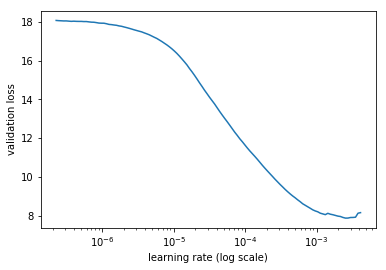

In [31]:
learn.lr_find(start_lr=1e-7)
learn.sched.plot()

### Train

In [32]:
lr = 5e-5

In [38]:
learn.fit(lr, 1, cycle_len=1)
#size:224,bs:50 -> 3.14
  # 2 fc layers -> 3.11

epoch      trn_loss   val_loss                              
    0      4.024855   3.780956  


[3.780956152008801]

In [39]:
learn.fit(lr, 1, cycle_len=1)
#size:224,bs:50 -> 3.12
  # 2 fc layers -> 3.09

epoch      trn_loss   val_loss                              
    0      3.757156   3.663228  


[3.663228476919779]

In [40]:
learn.fit(lr, 1, cycle_len=5, wds=1e-7, use_clr=(20,5))
# sz:224,bs:50
# epoch      trn_loss   val_loss                              
#     0      3.105776   3.117618  
#     1      3.050825   3.117392                              
#     2      3.018535   3.07232                               
#     3      2.989161   3.079901                              
#     4      2.961748   3.067656 

# sz:128,bs:100

epoch      trn_loss   val_loss                              
    0      3.726436   3.661549  
    1      3.658091   3.630372                              
    2      3.639272   3.623037                              
    3      3.623435   3.618576                              
    4      3.620704   3.615284                              


[3.615284117256723]

In [41]:
learn.save('attn-224-7iters')

### Test

In [42]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return idstoline(ints)
#     return ''.join([itos[i] for i in ints])

In [44]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

In [45]:
def decode(probs):
    # probs.shape = ([20, 50, 4085])
    probs = probs.permute(1, 0, 2).cpu().data.numpy()  #=> (50, 20, 4085)
    return np.argmax(probs, 2)                        #=> (50, 20)

In [46]:
x,y = next(iter(learn.data.val_dl))
probs = learn.model(V(x))                          
preds = decode(probs)

In [55]:
preds[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


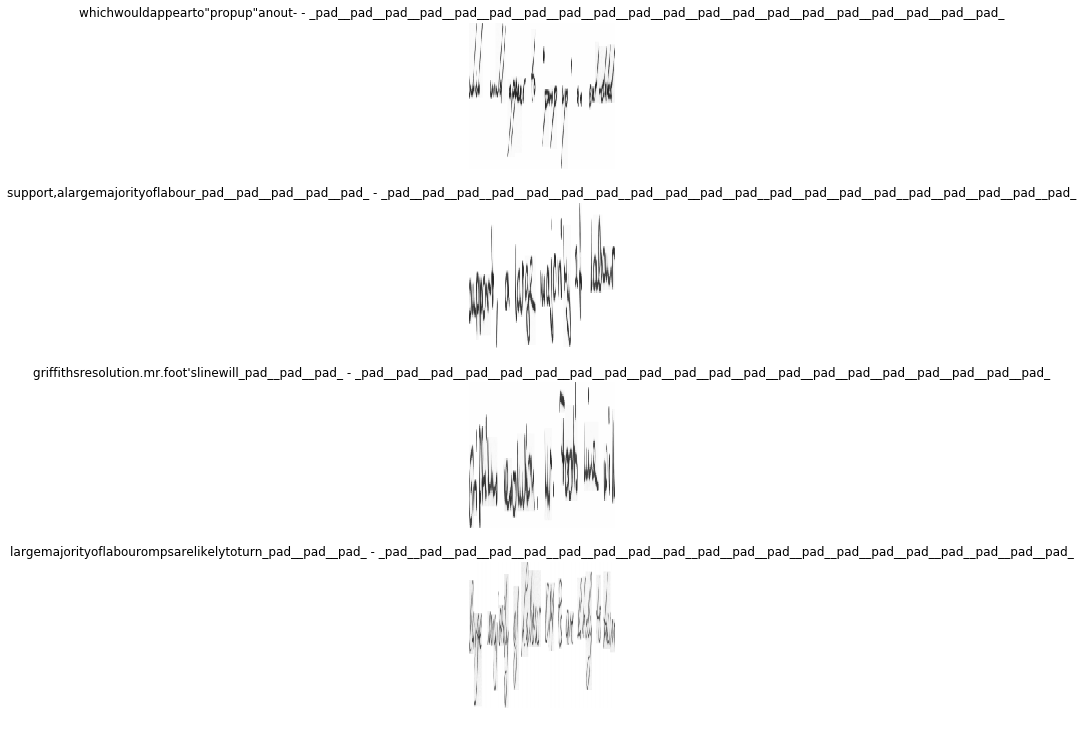

In [48]:
imgs = denorm(x)

fig, axes = plt.subplots(4,1, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i]) + ' - ' + label_text(preds[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)